In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm as tqdm
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

In [2]:
print(torch.__version__)

1.12.1+cu116


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
data_dir = str(Path(fr"./data/train.csv"))
testdata_dir = str(Path(fr"./data/test.csv"))
save_dir = str(Path(fr"./runs/exp"))

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 2000

epoch_num = 1000

dtype = torch.float64

# Learning Rate
LR = 1e-3
EPS = 1e-7
LR_STEP = 100
LR_GAMMA = 0.5

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, dtype=torch.float, transform=None):
        data = pd.read_csv(data_dir)
        self.inputs = data[['x1', 'x2']].to_numpy()
        self.outputs = data['y'].to_numpy()
        self.dtype = dtype
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype=dtype)
        output_data = torch.tensor(self.outputs[idx], dtype=dtype)

        if self.transform:
            input_data = self.transform(input_data)

        return input_data, output_data

In [7]:
class _Block(nn.Module):
    def __init__(
            self, 
            num_input_features, 
            num_output_features, 
            activation_list,
            drop_rate: float
    ) -> None:
        super().__init__()
        self.add_module("linear", nn.Linear(num_input_features, num_output_features))
        self.add_module("norm", nn.BatchNorm1d(num_output_features))
        self.activation_list = activation_list
        self.drop_rate = float(drop_rate)

    def forward(self, input):

        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input
        
        x = torch.cat(prev_features, 1)

        x = self.linear(x)
        x = self.norm(x)
        features = []
        for acivate in self.activation_list:
            features.append(acivate(x))
        return torch.cat(features, 1)

In [8]:
class DeepMultiAFwithBNmodel(nn.Module):
    def __init__(
            self, 
            num_init_features: int,
            num_classes,
            block_config, 
            activation_list,
            drop_rate: float = 0
    ):
        super().__init__()

        self.features = nn.ModuleDict()

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _Block(num_features, num_layers, activation_list, drop_rate)
            self.features.add_module(f"block{i}", block)
            num_features = num_features + num_layers * len(activation_list)
        self.classifier = nn.Linear(num_features, num_classes)

        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # 使用Xavier初始化
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.features.items():
            new_features = layer(features)
            features.append(new_features)
        
        x = torch.cat(features, 1)
        x = self.classifier(x)
        return x

In [9]:
class DeepModelWithBN(nn.Module):
    def __init__(
            self, 
            layer_sizes):
        super().__init__()

        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes) - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i + 1]).to(dtype)
            nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化
            self.layers.append(layer)
            
            if i != len(layer_sizes) - 2:  # 不在最后一个线性层后使用批量归一化
                bn = nn.BatchNorm1d(layer_sizes[i + 1]).to(dtype)
                self.layers.append(bn)

        # self.activation = nn.LeakyReLU(0.01)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if isinstance(layer, nn.Linear):  # 只在线性层后使用激活函数
                x = self.activation(x)
        
        x = self.layers[-1](x)  # 最后一层不使用激活函数
        return x

In [10]:
class DeepModel(nn.Module):
    def __init__(
            self, 
            num_init_features: int,
            num_classes,
            block_config, 
            # activation_list,
            drop_rate: float = 0
    ):
        super().__init__()

        self.features = nn.Sequential()

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            layer = nn.Linear(num_features, num_layers)
            self.features.add_module(f"linear{i}", layer)
            if i % 2:
                self.features.add_module(f"ELU{i}", nn.ELU())
            else:
                self.features.add_module(f"Tanh{i}", nn.Tanh())
            # self.features.add_module(f"Tanh{i}", nn.Tanh())
            num_features = num_layers
        self.classifier = nn.Linear(num_features, num_classes)


        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # 使用Xavier初始化
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = self.classifier(features)

        return out

In [11]:
dataset = CustomDataset(data_dir)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_dataset, valid_dataset], [True, False])}


In [18]:
model_name = 'DeepModel'
# model_args = [2, 1, [32, 32, 64, 64, 64, 128, 64, 64, 64, 32, 32], [nn.Tanh(), nn.ReLU(), nn.ELU()]] 
model_args = [2, 1, [8, 16, 32, 64, 128, 64, 32, 16, 8]]
# model_args = [[2, 8, 16, 32, 32, 64, 128, 64, 32, 32, 16, 8, 1]]


# model = DeepModelWithBN(*model_args)
# model = DeepMultiAFwithBNmodel(*model_args)
model = DeepModel(*model_args)
model = model.to(dtype=dtype)

# model = EasyModel()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, eps=EPS)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=EPS, weight_decay=0.01)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# lr_scheduler = None
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.5, 
                                                          patience=30, 
                                                          verbose=True, 
                                                          threshold=0.0001, 
                                                          threshold_mode='rel', 
                                                          cooldown=50, 
                                                          min_lr=0, 
                                                          eps=EPS)

criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()
# criterion = nn.PoissonNLLLoss()
# criterion = nn.HuberLoss(reduction='mean', delta=1.0)

In [19]:
ckpt = {
    'epoch': 0,
    'model_name': model_name,
    'model_args': model_args,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'criterion': criterion,
    'history': {
        'train_loss': [], 
        'valid_loss': [],
        'valid_loss_min': np.Inf,
        'train_loss_min': np.Inf,
        'best_acc': 0.0,
    },
    'readme': "",
    'date': datetime.now().isoformat(),
}

In [14]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(
            ''), path.suffix) if path.is_file() else (path, '')

        # Method 1
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # increment path
            if not os.path.exists(p):  #
                break
        path = Path(p)

        # Method 2 (deprecated)
        # dirs = glob.glob(f"{path}{sep}*")  # similar paths
        # matches = [re.search(rf"{path.stem}{sep}(\d+)", d) for d in dirs]
        # i = [int(m.groups()[0]) for m in matches if m]  # indices
        # n = max(i) + 1 if i else 2  # increment number
        # path = Path(f"{path}{sep}{n}{suffix}")  # increment path

    if mkdir:
        path.mkdir(parents=True, exist_ok=True)  # make directory

    return str(path)

In [22]:
def train(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=300,
          dtype=torch.float32, 
          device='cpu'):

    save_dir = Path(save_dir)
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)
    
    model = model.to(dtype=dtype).to(device)

    # initial
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    for epoch in range(1, num_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # Training loop
        model.train()
        for inputs, outputs in dataloaders['train']:
            optimizer.zero_grad()
            
            inputs = inputs.to(dtype).to(device)
            outputs = outputs.to(dtype).to(device)

            predictions = model(inputs)
            loss = criterion(predictions.squeeze(1), outputs)
            loss.backward()
            optimizer.step()

            # update training loss
            train_loss += loss.item() * inputs.size(0)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for inputs, outputs in dataloaders['valid']:

                inputs = inputs.to(dtype).to(device)
                outputs = outputs.to(dtype).to(device)

                predictions = model(inputs)
                loss = criterion(predictions.squeeze(1), outputs)
                valid_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(dataloaders['train'].sampler)
        if len(dataloaders['valid'].dataset):
            valid_loss = valid_loss / len(dataloaders['valid'].sampler)
        if (lr_scheduler):
            lr_scheduler.step(train_loss)
        

        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['valid_loss'].append(valid_loss)

        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        
        # update and save check point information
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # save model if validation loss has decreased
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('valid_best.pth')))
        # save model if validation loss has decreased
        if train_loss <= ckpt['history']['train_loss_min']:
            print(
                f"train loss decreased ({ckpt['history']['train_loss_min']:.6f} \
                    --> {train_loss:.6f}).  Saving model ...")
            ckpt['history']['train_loss_min'] = train_loss
            torch.save(ckpt, str(Path(save_dir) / Path('train_best.pth')))

        torch.save(ckpt, str(Path(save_dir) / Path('last.pth')))

    return ckpt

In [85]:
ckpt['model_state_dict'] = torch.load(str(Path(fr"./runs/exp") / Path('last.pth')))['model_state_dict']

In [17]:
ckpt['lr_scheduler_state_dict'] = None

In [77]:
ckpt['criterion'] = nn.MSELoss()

In [41]:
k = iter(dataloaders['train'])
x, y = next(k)

predictions = model(x)
print(predictions.shape)
print(y.shape)
print(y.reshape(batch_size, 1).shape)
print(predictions.squeeze(1).shape)
print(criterion(predictions.squeeze(1), y))
print(criterion(predictions, y))
print(criterion(predictions, y.reshape(batch_size, 1)))

torch.Size([64, 1])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64])
tensor(1.2346, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.2805, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.2346, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [19]:
print(model)

DeepModel(
  (features): Sequential(
    (linear0): Linear(in_features=2, out_features=8, bias=True)
    (Tanh0): Tanh()
    (linear1): Linear(in_features=8, out_features=16, bias=True)
    (ELU1): ELU(alpha=1.0)
    (linear2): Linear(in_features=16, out_features=16, bias=True)
    (Tanh2): Tanh()
    (linear3): Linear(in_features=16, out_features=32, bias=True)
    (ELU3): ELU(alpha=1.0)
    (linear4): Linear(in_features=32, out_features=32, bias=True)
    (Tanh4): Tanh()
    (linear5): Linear(in_features=32, out_features=64, bias=True)
    (ELU5): ELU(alpha=1.0)
    (linear6): Linear(in_features=64, out_features=64, bias=True)
    (Tanh6): Tanh()
    (linear7): Linear(in_features=64, out_features=128, bias=True)
    (ELU7): ELU(alpha=1.0)
    (linear8): Linear(in_features=128, out_features=128, bias=True)
    (Tanh8): Tanh()
    (linear9): Linear(in_features=128, out_features=64, bias=True)
    (ELU9): ELU(alpha=1.0)
    (linear10): Linear(in_features=64, out_features=64, bias=True)


In [20]:
ckpt = train(ckpt, save_dir, model, dataloaders, optimizer, lr_scheduler=lr_scheduler, num_epochs=500, device=device)

running epoch: 1
Train loss     -> 1.038531                      Validation loss     -> 0.593522
Validation loss decreased (inf                     --> 0.593522).  Saving model ...
train loss decreased (inf                     --> 1.038531).  Saving model ...
running epoch: 2
Train loss     -> 0.497784                      Validation loss     -> 0.232355
Validation loss decreased (0.593522                     --> 0.232355).  Saving model ...
train loss decreased (1.038531                     --> 0.497784).  Saving model ...
running epoch: 3
Train loss     -> 0.213097                      Validation loss     -> 0.198684
Validation loss decreased (0.232355                     --> 0.198684).  Saving model ...
train loss decreased (0.497784                     --> 0.213097).  Saving model ...
running epoch: 4
Train loss     -> 0.207035                      Validation loss     -> 0.233911
train loss decreased (0.213097                     --> 0.207035).  Saving model ...
running epoch: 5
Tr

In [31]:
ckpt1 = torch.load(str(Path(fr"./runs/exp34") / Path('last.pth')))
ckpt2 = torch.load(str(Path(fr"./runs/exp38") / Path('last.pth')))

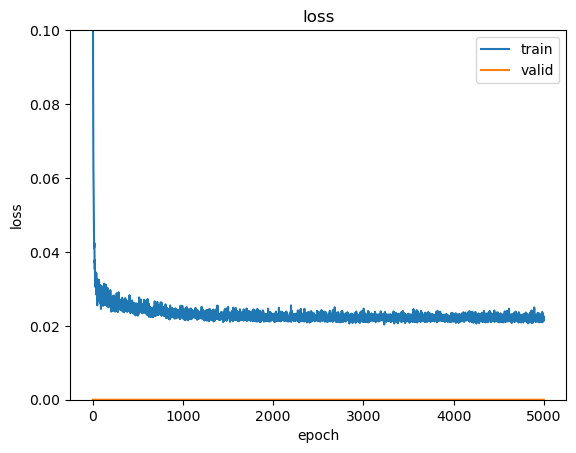

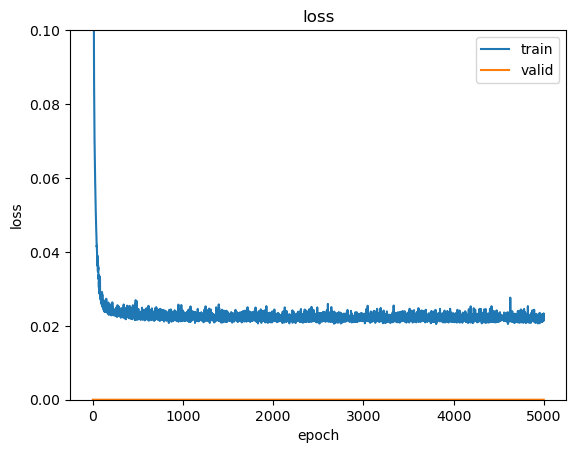

In [35]:
plot_k_res([ckpt1, ckpt2])

In [34]:
def plot_k_res(list):
    # loss 
    for i in list:
        plt.plot(i['history']['train_loss'],label='train')
        plt.plot(i['history']['valid_loss'],label='valid')
        plt.legend()
        plt.ylim(0,0.1)
        plt.title('loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

Fold 1
running epoch: 1
Train loss     -> 1.090693                      Validation loss     -> 0.613734
Validation loss decreased (inf                     --> 0.613734).  Saving model ...
train loss decreased (inf                     --> 1.090693).  Saving model ...
running epoch: 2
Train loss     -> 0.470097                      Validation loss     -> 0.237085
Validation loss decreased (0.613734                     --> 0.237085).  Saving model ...
train loss decreased (1.090693                     --> 0.470097).  Saving model ...
running epoch: 3
Train loss     -> 0.199518                      Validation loss     -> 0.193401
Validation loss decreased (0.237085                     --> 0.193401).  Saving model ...
train loss decreased (0.470097                     --> 0.199518).  Saving model ...
running epoch: 4
Train loss     -> 0.205665                      Validation loss     -> 0.245008
running epoch: 5
Train loss     -> 0.217461                      Validation loss     -> 0.189540

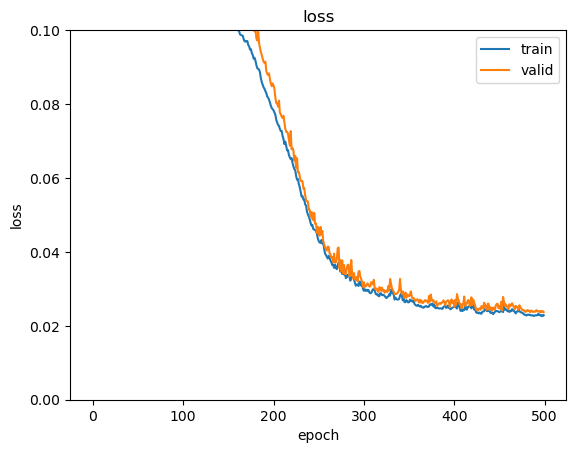

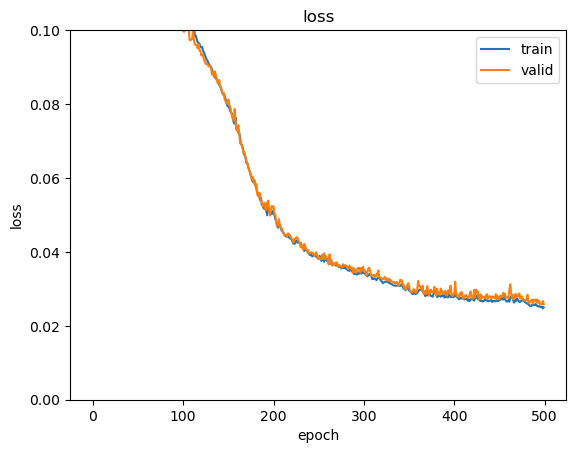

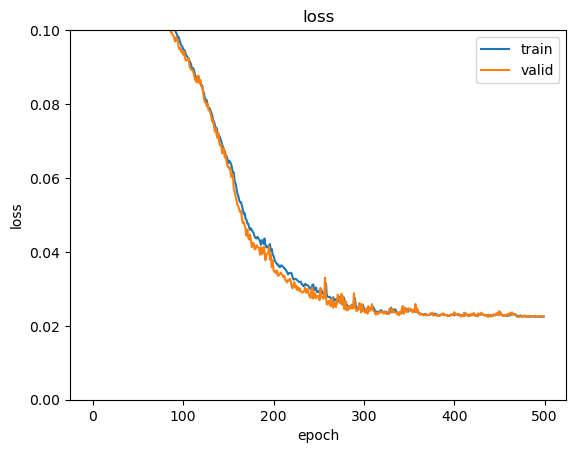

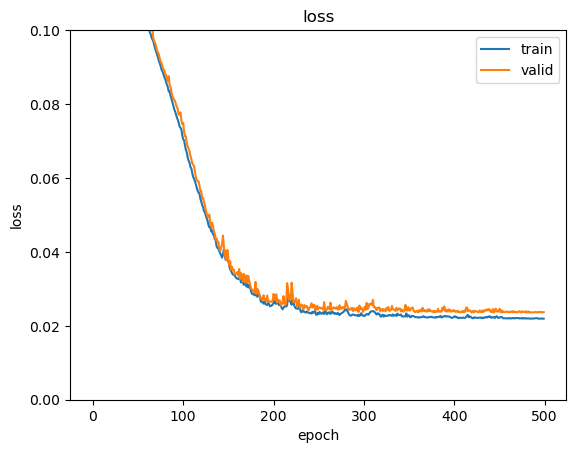

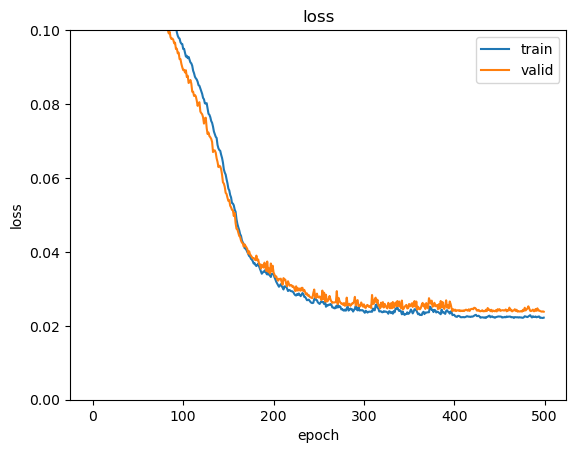

In [36]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

train_losses_k = []
valid_losses_k = []
ckpt_list = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold + 1}")

    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)

    dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
            for x, y, z in zip(['train', 'valid'], [train_subset, val_subset], [True, False])}
    
    model_name = 'DeepModel'
    model_args = [2, 1, [8, 16, 32, 64, 128, 64, 32, 16, 8]]

    model = DeepModel(*model_args)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, eps=EPS)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode='min', 
                                                            factor=0.5, 
                                                            patience=30, 
                                                            verbose=True, 
                                                            threshold=0.0001, 
                                                            threshold_mode='rel', 
                                                            cooldown=50, 
                                                            min_lr=0, 
                                                            eps=EPS)

    criterion = nn.MSELoss()

    ckpt = {
        'epoch': 0,
        'model_name': model_name,
        'model_args': model_args,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        'criterion': criterion,
        'history': {
            'train_loss': [], 
            'valid_loss': [],
            'valid_loss_min': np.Inf,
            'train_loss_min': np.Inf,
            'best_acc': 0.0,
        },
        'readme': "",
        'date': datetime.now().isoformat(),
    }

    ckpt = train(ckpt, save_dir, model, dataloaders, optimizer, lr_scheduler=lr_scheduler, num_epochs=500, device=device)


    # 保存训练和验证损失
    train_losses_k.append(ckpt['history']['train_loss_min'])
    valid_losses_k.append(ckpt['history']['valid_loss_min'])
    ckpt_list.append(ckpt)

# 输出交叉验证结果
print(f"Average Train Loss: {np.mean(train_losses_k):.4f}, Average Val Loss: {np.mean(valid_losses_k):.4f}")
plot_k_res(ckpt_list)

In [ ]:
def k_fold_cross_validation(dataset, model_class, model_args, criterion, k_folds=5, epochs=500, batch_size=64, dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    fold_train_losses = []
    fold_val_losses = []
    fold_best_models = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}")

        train_subset = torch.utils.data.Subset(dataset, train_indices)
        val_subset = torch.utils.data.Subset(dataset, val_indices)

        dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_subset, val_subset], [True, False])}

        model = model_class(*model_args).to(dtype).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        early_stopping = EarlyStopping(patience=5, delta=0.0001)

        best_val_loss = float("inf")
        best_model_weights = None


        for epoch in range(epochs):
            train_loss = train(model, train_dataloader, criterion, optimizer, device)
            val_loss = validate(model, val_dataloader, criterion, device)

            print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = model.state_dict().copy()

            if early_stopping(val_loss):
                print("Early stopping triggered.")
                break

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_best_models.append(best_model_weights)

    return fold_train_losses, fold_val_losses, fold_best_models


In [18]:
ckpt['lr_scheduler_state_dict']

{'factor': 0.5,
 'min_lrs': [0],
 'patience': 30,
 'verbose': True,
 'cooldown': 50,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 0.021724874212322512,
 'num_bad_epochs': 2,
 'mode_worse': inf,
 'eps': 1e-07,
 'last_epoch': 1641,
 '_last_lr': [1.220703125e-07]}

In [64]:
ckpt = torch.load(str(Path(fr"./runs/exp34") / Path('last.pth')))
print(ckpt.keys())
print(ckpt['model_name'])
print(ckpt['epoch'])
print(ckpt['model_args'])

dict_keys(['epoch', 'model_name', 'model_args', 'model_state_dict', 'optimizer_state_dict', 'lr_scheduler_state_dict', 'criterion', 'history', 'readme', 'date'])
DeepMultiAFwithBNmodel
5000
[2, 1, [2, 32, 64, 128, 128, 64, 32, 1], [Tanh(), ReLU(), LeakyReLU(negative_slope=0.01)]]


Text(0, 0.5, 'loss')

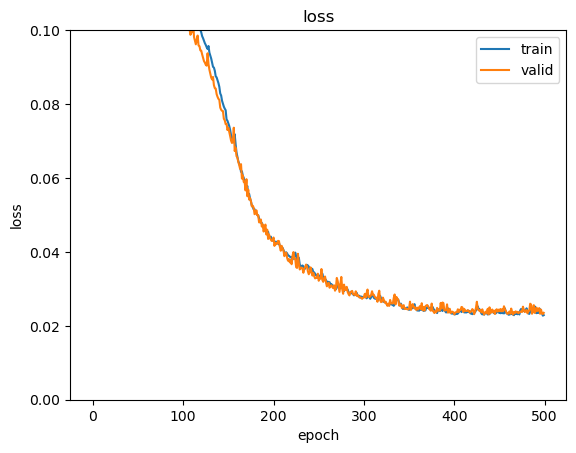

In [21]:
# loss 
plt.plot(ckpt['history']['train_loss'][:500],label='train')
plt.plot(ckpt['history']['valid_loss'][:500],label='valid')
plt.legend()
# plt.xlim(50,)
plt.ylim(0,0.1)
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [55]:
model = DeepMultiAFwithBNmodel(*ckpt['model_args'])

DeepMultiAFwithBNmodel


In [57]:
model.load_state_dict(torch.load(str(Path(fr"./runs/exp87") / Path('train_best.pth')))['model_state_dict'])

<All keys matched successfully>

In [44]:
model.to(device)
model = model.to(dtype=dtype)
data = pd.read_csv(testdata_dir)
x = data[['x1', 'x2']].to_numpy()
x = torch.tensor(x, dtype=dtype)
model.eval()
with torch.no_grad():
    y = model(x.to(device))

y = y.squeeze().cpu().numpy()
ids = np.arange(1, 2001)
df = pd.DataFrame({'id': ids, 'y': y})
df.to_csv('output_last.csv', index=False)

In [188]:
# files_list = ["runs/exp30/output_best.csv", 
#               "runs/exp34/output_best.csv", 
#               "runs/exp34/output_last.csv", 
#               "runs/exp35/output_best.csv", 
#               "runs/exp35/output_last.csv", 
#               "runs/exp36/output_best.csv",
#               "runs/exp36/output_last.csv",
#               "runs/exp38/output_best.csv",
#               "runs/exp38/output_last.csv",
#               "runs/exp39/output_last.csv",
#               "runs/exp40/output_best.csv",
#               "runs/exp40/output_last.csv",
#               "runs/exp41/output_best.csv",
#               "runs/exp45/output_best.csv",
#               "runs/exp49/output_best.csv",
#               "runs/exp49/output_last.csv",
#               "merged_data.csv", 
#               ]
# files_list = ["merged_data.csv", 
#               "output_file.csv", 
#               ]
# files_list = [
#               "merged_data_v2.csv", 
#               "merged_data_v3.csv", 
#               ]
files_list = ["runs/exp61/output_best.csv",
              "runs/exp60/output_best.csv",
              "merged_data_v3.csv", 
              ]

# 初始化一個空的DataFrame用於存儲結果
merged_data = pd.DataFrame()

for index, file in enumerate(files_list):
    # 讀取CSV檔案
    data = pd.read_csv(file)
    
    # 使用檔案名稱或索引作為新列名
    new_column_name = f'y_{index}' 
    
    # 將y值重命名為新列名
    data = data.rename(columns={'y': new_column_name})
    
    # 合併檔案
    if merged_data.empty:
        merged_data = data
    else:
        merged_data = merged_data.merge(data, on='id', how='outer')

# 計算y值的平均
merged_data['y'] = merged_data.iloc[:, 1:].mean(axis=1)

# 將結果輸出到CSV檔案
merged_data.to_csv('merged_data_v5.csv', index=False)


merged_data


,id,y_0,y_1,y_2,y
0,1,0.468848,0.476072,0.484593,0.476505
1,2,1.448495,1.440963,1.452454,1.447304
2,3,0.705663,0.697312,0.688127,0.697034
3,4,1.360311,1.361011,1.368883,1.363402
4,5,1.464402,1.445366,1.473690,1.461153
...,...,...,...,...,...
1995,1996,1.394386,1.402734,1.386946,1.394689
1996,1997,0.516036,0.516588,0.534625,0.522417
1997,1998,1.491646,1.498870,1.477600,1.489372
1998,1999,0.611278,0.592025,0.622809,0.608704


In [190]:
columns_to_drop = merged_data.iloc[:,1:-1].columns
print(columns_to_drop)
merged_data = merged_data.drop(columns=columns_to_drop)
merged_data.to_csv('merged_data_v5.csv', index=False)
merged_data

Index([], dtype='object')


,id,y
0,1,0.476505
1,2,1.447304
2,3,0.697034
3,4,1.363402
4,5,1.461153
...,...,...
1995,1996,1.394689
1996,1997,0.522417
1997,1998,1.489372
1998,1999,0.608704


In [44]:


# 讀取兩個CSV檔
csv1 = pd.read_csv('output.csv')
csv2 = pd.read_csv('output2.csv')

# 使用相同的id將兩個dataframe合併
merged_csv = csv1.merge(csv2, on='id', suffixes=('_1', '_2'))

# 計算y值的平均值
merged_csv['y'] = (merged_csv['y_1'] + merged_csv['y_2']) / 2

# 保存到新的CSV檔
merged_csv[['id', 'y']].to_csv('output_file.csv', index=False)

<Figure size 640x480 with 0 Axes>

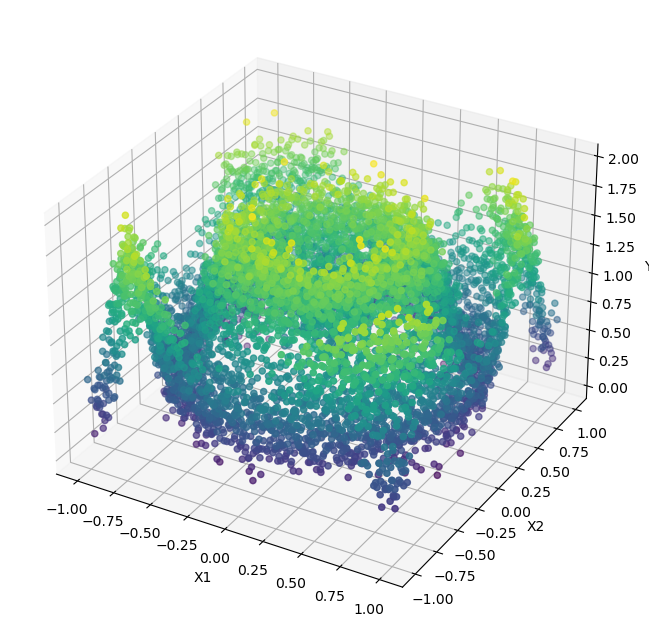

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv(data_dir)

# 創建一個3D圖形
fig = plt.figure()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
ax.scatter(data['x1'].to_numpy(), 
           data['x2'].to_numpy(), 
           data['y'].to_numpy(), 
           c=data['y'].to_numpy(), 
           cmap='viridis', 
           marker='o')

# 設置標籤
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')



# 顯示圖形
plt.show()

<Figure size 640x480 with 0 Axes>

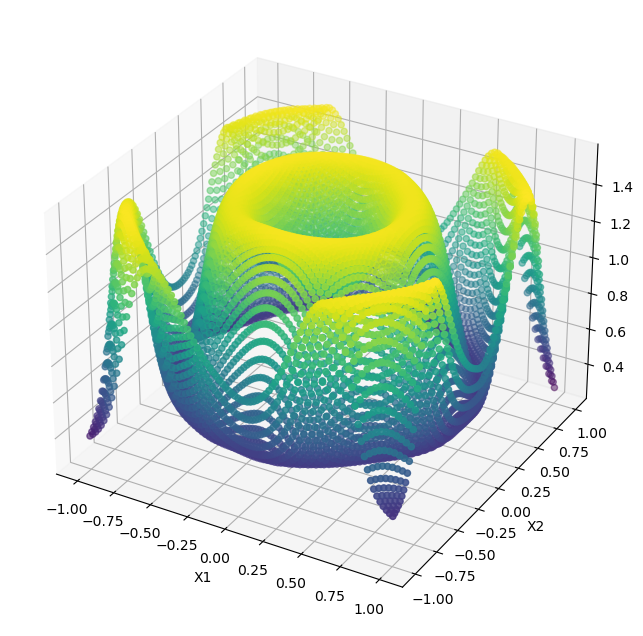

In [58]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D


# 設定網格點的數量
grid_size = 100

# 使用linspace在-1和1之間創建均勻間隔的值
x_values = np.linspace(-1, 1, grid_size)
y_values = np.linspace(-1, 1, grid_size)

# 使用meshgrid創建網格座標
x_grid, y_grid = np.meshgrid(x_values, y_values)

# 將網格座標陣列整形為2D點陣列
x = np.column_stack((x_grid.flatten(), y_grid.flatten()))

x_t = torch.tensor(x, dtype=dtype)
model = model.to(device)
model.eval()
with torch.no_grad():
    y = model(x_t.to(device))
y = y.squeeze().cpu().numpy()

data = pd.DataFrame({'x1': x[:, 0], 'x2': x[:, 1], 'y': y})

# 創建一個3D圖形
fig = plt.figure()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
ax.scatter(data['x1'].to_numpy(), data['x2'].to_numpy(), data['y'].to_numpy(), c=data['y'].to_numpy(), cmap='viridis', marker='o')

# 設置標籤
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')



# 顯示圖形
plt.show()

In [128]:

# df.to_csv('.csv', index=False)

<Figure size 640x480 with 0 Axes>

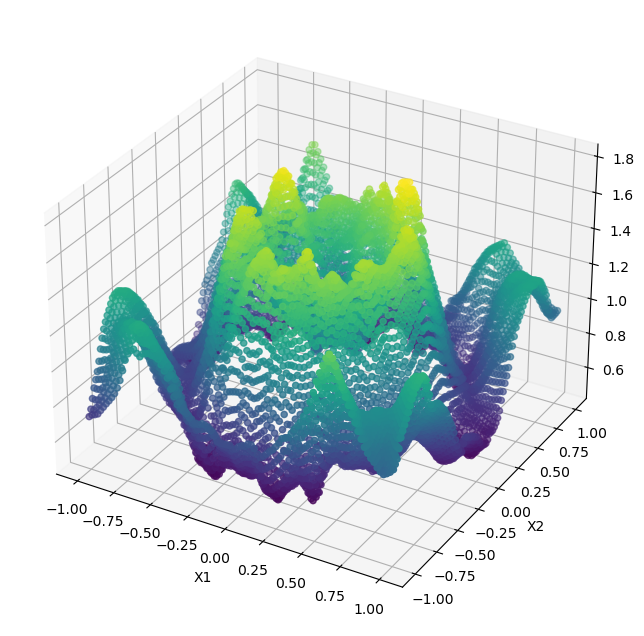

In [129]:


data = df



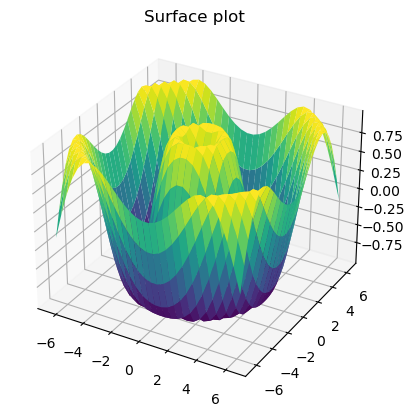

In [65]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

a = 2.5
b = 0.6
c = 6.4

x = np.outer(np.linspace(-c, c, 30), np.ones(30))
y = x.copy().T # transpose

z = np.sin(np.sqrt(a * (x * b)**2 + a * (y * b)**2))

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()